## Dominant Topic and it distrubution on each sentence

In [1]:
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim

In [2]:
#Import all the necessary packages
import pandas as pd
from gensim import corpora, models, similarities
import gensim
import numpy as np
import pickle
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

/Users/harika_pradeep/miniconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
#Load model
ldamallet_model = models.LdaModel.load('/Users/harika_pradeep/ldamallet.lda')

In [4]:
#Load corpus
corpus = corpora.MmCorpus('/Users/harika_pradeep/amzn_h_k_sentences.mm')

In [5]:
#Load Dictionary
texts_dict_unq =  corpora.Dictionary.load('auto_review_s.dict')

In [6]:
#To load texts (tokenized)
with open('/Users/harika_pradeep/texts_s.pkl', 'rb') as f:
    texts = pickle.load(f)

In [7]:
mallet_path = '/Users/harika_pradeep/Downloads/mallet-2.0.8/bin/mallet'

In [8]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=texts_dict_unq)

In [9]:
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('count', 0.06613899962585955),
   ('hate', 0.06406187508869708),
   ('changing', 0.04849634245461935),
   ('debating', 0.02964740488446801),
   ('cooker', 0.027796054753518856),
   ('addict', 0.025525409296744978),
   ('posted', 0.02475777631561972),
   ('sushi_rice', 0.02362245358723278),
   ('faded', 0.021945272283933892),
   ('picking', 0.021822709034846666)]),
 (1,
  [('slightly', 0.03889617199790246),
   ('cooker', 0.0385487676979549),
   ('preparation', 0.02573413738856843),
   ('fence', 0.02435762978500262),
   ('simutaneously', 0.020916360776088095),
   ('egg', 0.017258783429470372),
   ('small', 0.017049029889879393),
   ('tinola', 0.01585605663345569),
   ('goodness', 0.015561090718405873),
   ('friendly', 0.014368117461982171)]),
 (2,
  [('channel', 0.21367270088699286),
   ('handy', 0.1584889845245393),
   ('explained', 0.1431761600340285),
   ('update', 0.09842618192736417),
   ('worth_every', 0.07318003828206122),
   ('caused', 0.06065705027960917),
   ('daily', 

In [10]:
from gensim.models.coherencemodel import CoherenceModel
#Coeherenc coefficient calculation for Mallet LDA
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=texts_dict_unq, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.585345235350918


In [11]:

#create a merged list of stop words
nltk_stpwd = stopwords.words('english')
#Extend stopwords with commonly found tokens in review texts
#nltk_stpwd.extend(['generally', 'used', 'personally', 'review', 'honestly','truly','whatever','done','star','one','two','three','four','five','since','ever','even','much','thing','also','go','come','must'])
stopwords_stpwd = get_stop_words('en')
stop_words = list(set(nltk_stpwd + stopwords_stpwd))

print(len(set(stop_words)))
print(stop_words[:10])

211
['there', "he'll", 'ain', 'could', 'from', "we've", 'ma', 'by', 'no', 'm']


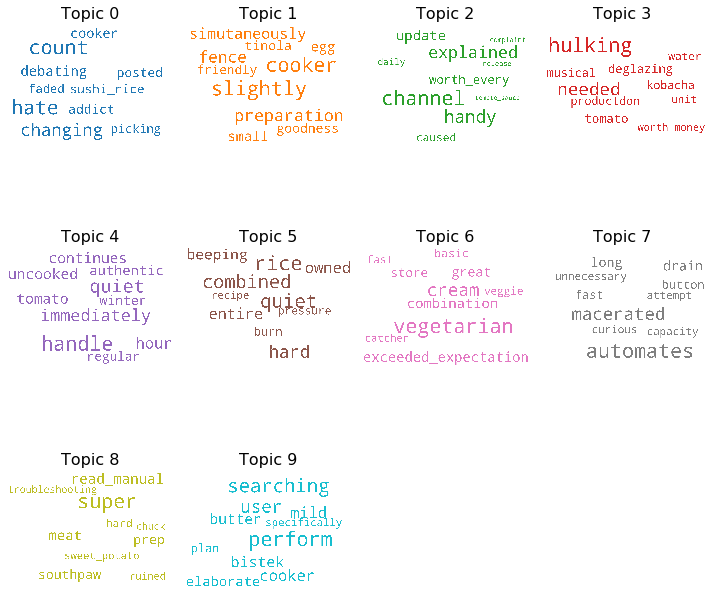

In [12]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(3, 4, figsize=(10,10), sharex=True, sharey=True)
fig.delaxes(axes[2,2]) 
fig.delaxes(axes[2,3]) 
for i, ax in enumerate(axes.flatten()):
    if(i<10):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [13]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [14]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts)

In [15]:
df_topic_sents_keywords.shape

(300677, 4)

In [16]:
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,5.0,0.2258,"rice, quiet, combined, hard, owned, entire, be...","[excited, soon, followed, manual, setting, bro..."
1,5.0,0.1607,"rice, quiet, combined, hard, owned, entire, be...","[ended, best, texture, brown, jasmine, rice, j..."
2,5.0,0.1852,"rice, quiet, combined, hard, owned, entire, be...","[plus, aroma, stayed, rice, really, fragrant, ..."
3,5.0,0.1967,"rice, quiet, combined, hard, owned, entire, be...","[quietest, rice, cooker, pressure, cooker, see..."
4,5.0,0.1303,"rice, quiet, combined, hard, owned, entire, be...","[quiet, musical, beeping, opening, closing, ti..."


In [28]:
df_topic_sents_keywords.to_csv("/Users/harika_pradeep/Downloads/df_topic_sents_keywords.csv")

In [29]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [30]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.2258,"rice, quiet, combined, hard, owned, entire, be...","[excited, soon, followed, manual, setting, bro..."
1,1,5.0,0.1607,"rice, quiet, combined, hard, owned, entire, be...","[ended, best, texture, brown, jasmine, rice, j..."
2,2,5.0,0.1852,"rice, quiet, combined, hard, owned, entire, be...","[plus, aroma, stayed, rice, really, fragrant, ..."
3,3,5.0,0.1967,"rice, quiet, combined, hard, owned, entire, be...","[quietest, rice, cooker, pressure, cooker, see..."
4,4,5.0,0.1303,"rice, quiet, combined, hard, owned, entire, be...","[quiet, musical, beeping, opening, closing, ti..."
5,5,9.0,0.1250,"perform, searching, user, cooker, mild, bistek...","[tell, except, display, front, metal, part, to..."
6,6,6.0,0.1379,"vegetarian, cream, exceeded_expectation, combi...","[tell, cooking, time, ended, hear, chime, pres..."
7,7,1.0,0.1259,"slightly, cooker, preparation, fence, simutane...","[automatic, switch, warm, holding, nice, timer..."
8,8,1.0,0.1111,"slightly, cooker, preparation, fence, simutane...","[condensation, catcher, back, needed]"
9,9,1.0,0.1153,"slightly, cooker, preparation, fence, simutane...","[everything, stayed, inside]"


In [31]:
df_dominant_topic.shape

(300677, 5)

In [32]:
print(df_dominant_topic.loc[[0]].values)

[[0 5.0 0.2258
  'rice, quiet, combined, hard, owned, entire, beeping, burn, pressure, recipe'
  list(['excited', 'soon', 'followed', 'manual', 'setting', 'brown', 'rice', 'recipe', 'included', 'cookbook', 'instead', 'using', 'rice', 'program', 'button', 'brown_rice'])]]


In [38]:
df_dominant_topic.tail(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
300667,300667,6.0,0.1407,"vegetarian, cream, exceeded_expectation, combi...","[picture, people, posted, trash, mess, dog, ma..."
300668,300668,1.0,0.1321,"slightly, cooker, preparation, fence, simutane...","[trash, fault, fault]"
300669,300669,4.0,0.1132,"handle, quiet, immediately, hour, continues, u...","[invest, crate, obedience, school]"
300670,300670,9.0,0.1176,"perform, searching, user, cooker, mild, bistek...","[trash, problem]"
300671,300671,8.0,0.1235,"super, read_manual, meat, prep, southpaw, hard...","[well, made, quality, trash]"
300672,300672,2.0,0.1720,"channel, handy, explained, update, worth_every...","[recieved, saturday, today, wednesday, first, ..."
300673,300673,0.0,0.1000,"count, hate, changing, debating, cooker, addic...",[]
300674,300674,0.0,0.1000,"count, hate, changing, debating, cooker, addic...",[]
300675,300675,9.0,0.1152,"perform, searching, user, cooker, mild, bistek...","[take, trash, never, give]"
300676,300676,9.0,0.1176,"perform, searching, user, cooker, mild, bistek...","[trash, taker]"


In [42]:
df_dominant_topic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300677 entries, 0 to 300676
Data columns (total 5 columns):
Document_No           300677 non-null int64
Dominant_Topic        300677 non-null float64
Topic_Perc_Contrib    300677 non-null float64
Keywords              300677 non-null object
Text                  300677 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 13.8+ MB


In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [44]:

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3359,"count, hate, changing, debating, cooker, addic...","[beautiful, color, purple, super, soft, compla..."
1,1.0,0.3237,"slightly, cooker, preparation, fence, simutane...","[great, gift, best, food, storage, container, ..."
2,2.0,0.3951,"channel, handy, explained, update, worth_every...","[love, love, sheet, great, cali, king, good, p..."
3,3.0,0.3780,"hulking, needed, tomato, deglazing, musical, p...","[star, washed, carpet, probably, time, every, ..."
4,4.0,0.4031,"handle, quiet, immediately, hour, continues, u...","[perfect, little, container, keep, water, cold..."


In [45]:
sent_topics_sorteddf_mallet.shape

(10, 4)

In [46]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 2)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"rice, quiet, combined, hard, owned, entire, be...",73608.0,0.24
1.0,5.0,"rice, quiet, combined, hard, owned, entire, be...",24937.0,0.08
2.0,5.0,"rice, quiet, combined, hard, owned, entire, be...",30092.0,0.10
3.0,5.0,"rice, quiet, combined, hard, owned, entire, be...",28868.0,0.10
4.0,5.0,"rice, quiet, combined, hard, owned, entire, be...",25340.0,0.08
...,...,...,...,...
300672.0,2.0,"channel, handy, explained, update, worth_every...",NaN,NaN
300673.0,0.0,"count, hate, changing, debating, cooker, addic...",NaN,NaN
300674.0,0.0,"count, hate, changing, debating, cooker, addic...",NaN,NaN
300675.0,9.0,"perform, searching, user, cooker, mild, bistek...",NaN,NaN


In [47]:
df_dominant_topics.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 300677 entries, 0.0 to 300676.0
Data columns (total 4 columns):
Dominant_Topic    300677 non-null float64
Topic_Keywords    300677 non-null object
Num_Documents     10 non-null float64
Perc_Documents    10 non-null float64
dtypes: float64(3), object(1)
memory usage: 11.5+ MB


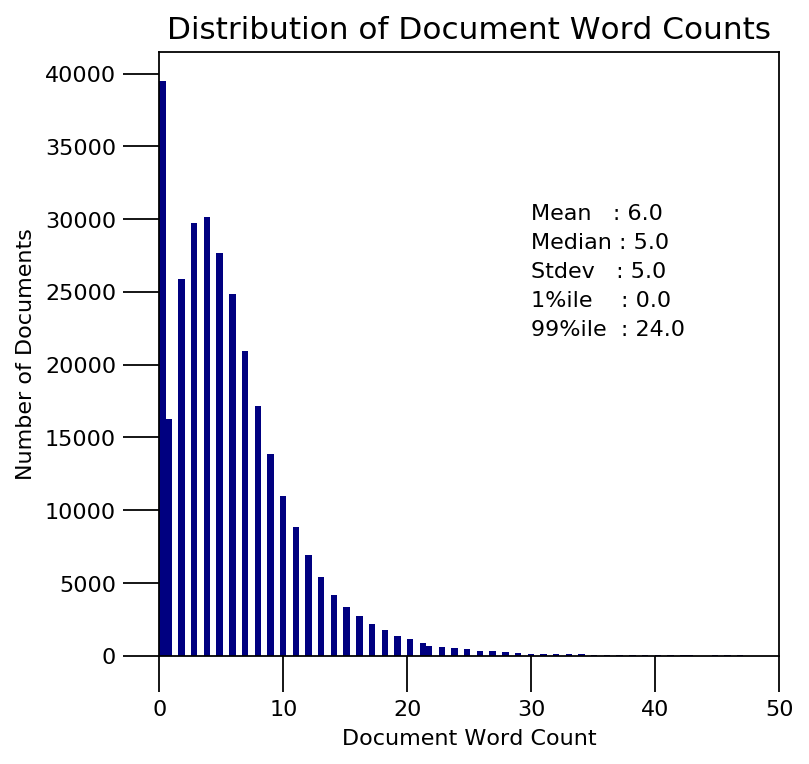

In [48]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(30, 30000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(30, 28000, "Median : " + str(round(np.median(doc_lens))))
plt.text(30, 26000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(30, 24000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(30, 22000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 50), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,50,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=14))
plt.show()

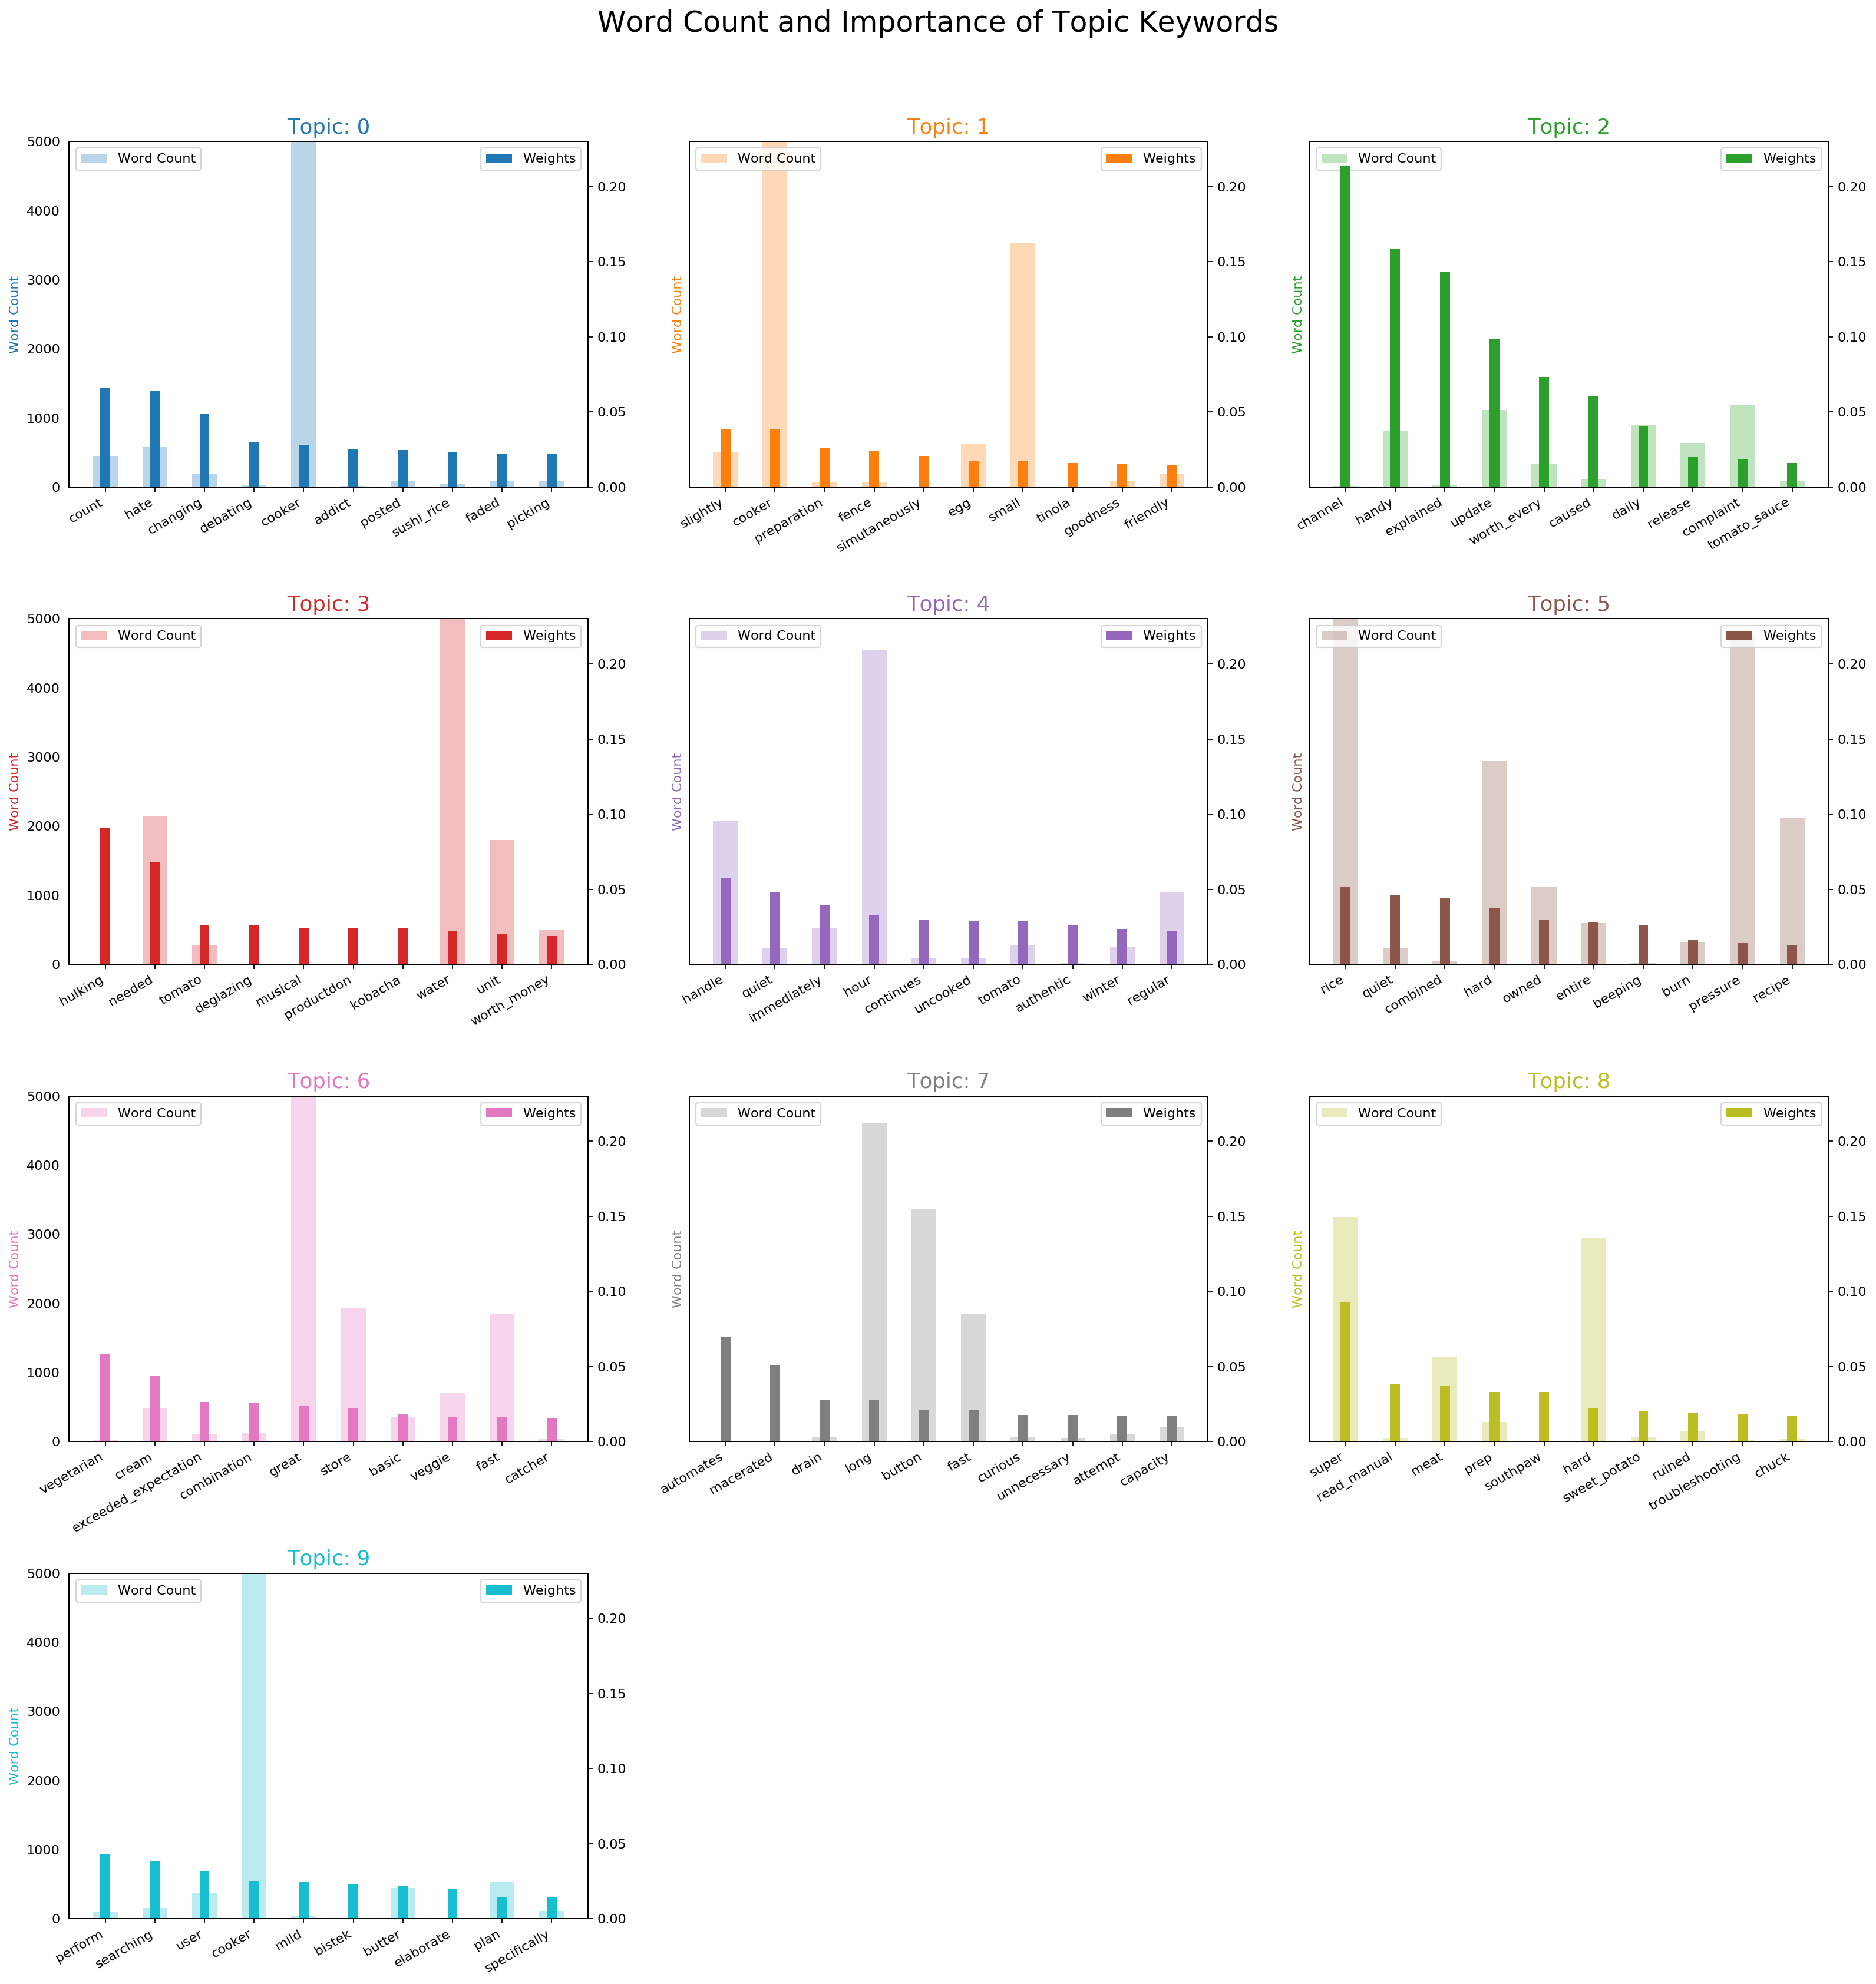

In [53]:
from collections import Counter
topics = ldamallet.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
fig.delaxes(axes[3,1]) 
fig.delaxes(axes[3,2]) 
for i, ax in enumerate(axes.flatten()):
    if(i<10):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.23); ax.set_ylim(0, 5000)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


### Reference Links
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence <br>
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/